### Example of Symbolic Regression to estimate LAI from spectral and structural data in vineyards

Data generated by Sergio Alvarez, GRAPEX project.
File 'RGBNIR_DSM_CHM_VIf_v4.csv' contains as potential predictors
- Reflectance values from canopy
- Vegetation indices for canopy
- Geometric information (H, widht, etc) per vine
- two predictants (afc, LAI) in the last colunms.

### Instructions
- if not, create a anaconda environment, e.g. pysr
- once completed, in the terminal, 
- in the pysr environment installa modules:
- conda install pysr
- conda install matplotlib

- activate environment and pass two commands:
- conda activate pysr
- python -c "import pysr
- last commands will install julia libraries, necessary to run the notebook.

Julia and Julia dependencies are installed at first import:

In [1]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Now, let's import everything else as well as the PySRRegressor:


In [2]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Simple PySR example:


use Sergio's v4 dataset, predict LAI

In [3]:
df = pd.read_csv('newVI_BCC_lte_008.csv')
# print(df.head())
X = df.iloc[:,1:-3]
y = df.LAI
print(X.head())


        Red     Green      Blue       NIR        FC       ch1        CH  \
0  0.020630  0.030237  0.003344  0.219818  0.680556  2.275999  2.451676   
1  0.020253  0.030407  0.003233  0.223823  0.652778  2.180176  2.469830   
2  0.022048  0.030032  0.003725  0.210354  0.598958  2.232824  2.363652   
3  0.022679  0.030747  0.003710  0.220522  0.500000  1.980601  2.298613   
4  0.023883  0.028469  0.003943  0.198092  0.522569  2.300652  2.226254   

         wc        WC      geom  ...      RGRI       RI4XS        SI  \
0  1.076450  0.999317  5.576198  ...  0.682277  509.138228  0.981867   
1  1.077895  0.951482  5.123413  ...  0.666062  479.839566  0.981972   
2  0.965705  0.912254  4.814528  ...  0.734158  597.604433  0.981337   
3  0.908815  0.783081  3.565081  ...  0.737611  575.514103  0.980890   
4  0.817703  0.845029  4.328101  ...  0.838918  868.336743  0.981177   

          SR      TDVI       TGI       TVI      TriVI      VARI   VrNIRBI  
0  10.655179  0.396112  1.949825  1.1525

By default, we will set up 30 populations of expressions (which evolve independently except for migrations),# use 4 threads, and use `"best"` for our model selection strategy:

In [4]:
default_pysr_params = dict(
    populations=8,    # ^ Assuming we have 4 cores, this means 2 populations per core, so one is always running.
    population_size=27, # ^ Number of equations per population
    model_selection="best", #"score" is also an option,
    random_state=0, # this line ensure reproducible results
    maxsize=20, # maximum complexity of the equations
    deterministic=True, #   to ensure reproducible results
    parallelism='serial', # to avoid parallel computing issues on some systems, change to 'serial' if needed
    # select_k_features=10, # to automatically select few predictors from the entire set of predictor options, activate/deactive as you wish
    # denoise=True, # to remove scatteting on y, activate/deactivate as you wish
    verbosity =0,
    elementwise_loss= "L2DistLoss()",  #  (mean square)
    )

PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [5]:
# Learn equations
model = PySRRegressor(
    niterations=100, # number of optimization iterations
    binary_operators=["+", "*","-","/"],
    unary_operators=["sqrt", "exp", "log"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    **default_pysr_params,
)

model.fit(X, y)

c:\Users\alfon\.conda\envs\PySR\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.4299724   
	1         0.339314                                          sqrt(MSR)   
	2   >>>>  0.549452                                           MSR - SI   
	3         0.055059                                 FC + (VARI + GARI)   
	4         0.020748                          (FC + IKAW) * sqrt(DSWI4)   
	5         0.020704                  (FC + sqrt(GOSAVI)) * sqrt(DSWI4)   
	6         0.006369             ((FC + NormNIR) * sqrt(DSWI4)) * MRBVI   
	7         0.015535             (FC * (GARI + NIRv)) + (GARI + NDGlaI)   
	8         0.010496  GOSAVI + ((((-0.3808455 - MSR) - GEOM) * -0.05...   
	9         0.001466  (GOSAVI + (((-0.3808455 - MSR) - GEOM) * (-0.0...   
	10        0.005256  ((((((0.6111387 - MSR) * 2.440354) - GEOM) * -...   
	11        0.010874  ((((MSAVI * ((exp(VARI) - MSR) * 4.593234)) - ...   
	12        0.032381  (sqrt(sqrt(GCC)) + ((1.8579623 - MSR) * (WC * ...   
	13        0.000794  ((((sqrt(MSAVI * WC) * (0.46686336 - (MSR * GB...   
	
	        loss  complexity  
	0   0.158801           1  
	1   0.113107           2  
	2   0.065293           3  
	3   0.058485           5  
	4   0.057284           6  
	5   0.056110           7  
	6   0.055754           8  
	7   0.054894           9  
	8   0.053754          11  
	9   0.053597          13  
	10  0.053036          15  
	11  0.052463          16  
	12  0.050791          17  
	13  0.050670          20  
]

We can print the model, which will print out all the discovered expressions:

In [6]:
print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.4299724   
	1         0.339314                                          sqrt(MSR)   
	2   >>>>  0.549452                                           MSR - SI   
	3         0.055059                                 FC + (VARI + GARI)   
	4         0.020748                          (FC + IKAW) * sqrt(DSWI4)   
	5         0.020704                  (FC + sqrt(GOSAVI)) * sqrt(DSWI4)   
	6         0.006369             ((FC + NormNIR) * sqrt(DSWI4)) * MRBVI   
	7         0.015535             (FC * (GARI + NIRv)) + (GARI + NDGlaI)   
	8         0.010496  GOSAVI + ((((-0.3808455 - MSR) - GEOM) * -0.05...   
	9         0.001466  (GOSAVI + (((-0.3808455 - MSR) - GEOM) * (-0.0...   
	10        0.005256  ((((((0.6111387 - MSR) * 2.440354) - GEOM) * -...   
	11        0.010874  ((((MSAVI * ((exp(VARI) - MSR) * 4.593234)) - ...   
	12      

We can also view the SymPy format of the best expression:

In [7]:
model.sympy()

MSR - SI

We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

In [12]:
model.sympy(8)

GOSAVI + (-GEOM - MSR - 0.3808455)*(-0.059097555)/RCC

## Output

`model.equations_` is a Pandas DataFrame. We can export the results in various ways:

In [9]:
model.latex()

'MSR - SI'

These is also `model.sympy(), model.jax(), model.pytorch()`. All of these can take an index as input, to get the result for an arbitrary equation in the list.

We can also use `model.predict` for arbitrary equations, with the default equation being the one chosen by `model_selection`:

ypredict = model.predict(X)
ypredict_simpler = model.predict(X, 2)

print("Default selection MSE:", np.power(ypredict - y, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y, 2).mean())

Plotting the first 20 solutions

IndexError: single positional indexer is out-of-bounds

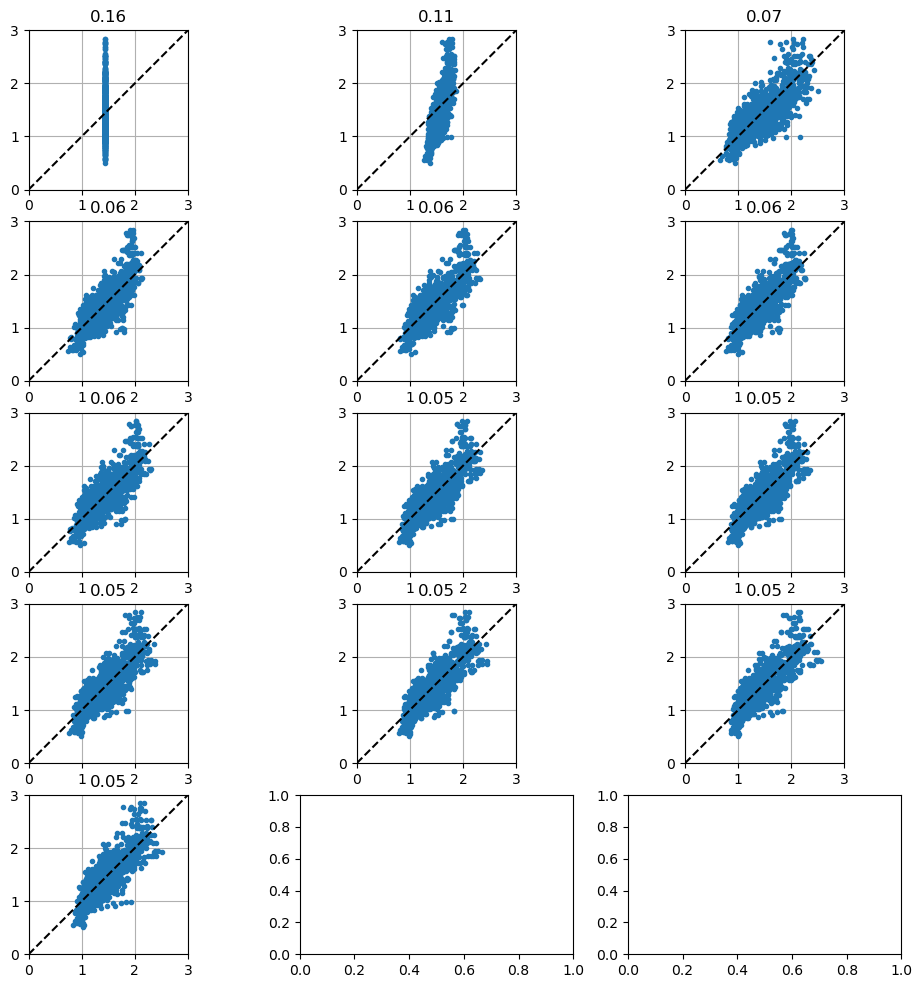

In [11]:
fig, axes = plt.subplots(5, 3, figsize=(12, 12))

it = np.linspace(0,15,14, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.plot(ypredict_simpler, y,'.')
    ax.grid(True)
    # ax.set_xlabel("Modeled LAI")
    # ax.set_ylabel("Measured LAI")
    ax.plot( [0,5], [0,5], linestyle='--', color='k' )

    ax.set_aspect('equal')
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    mse =np.power(ypredict_simpler - y, 2).mean()
    ax.set_title(round(mse,2))
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Plotting the difference between the predicted and measured LAI

IndexError: single positional indexer is out-of-bounds

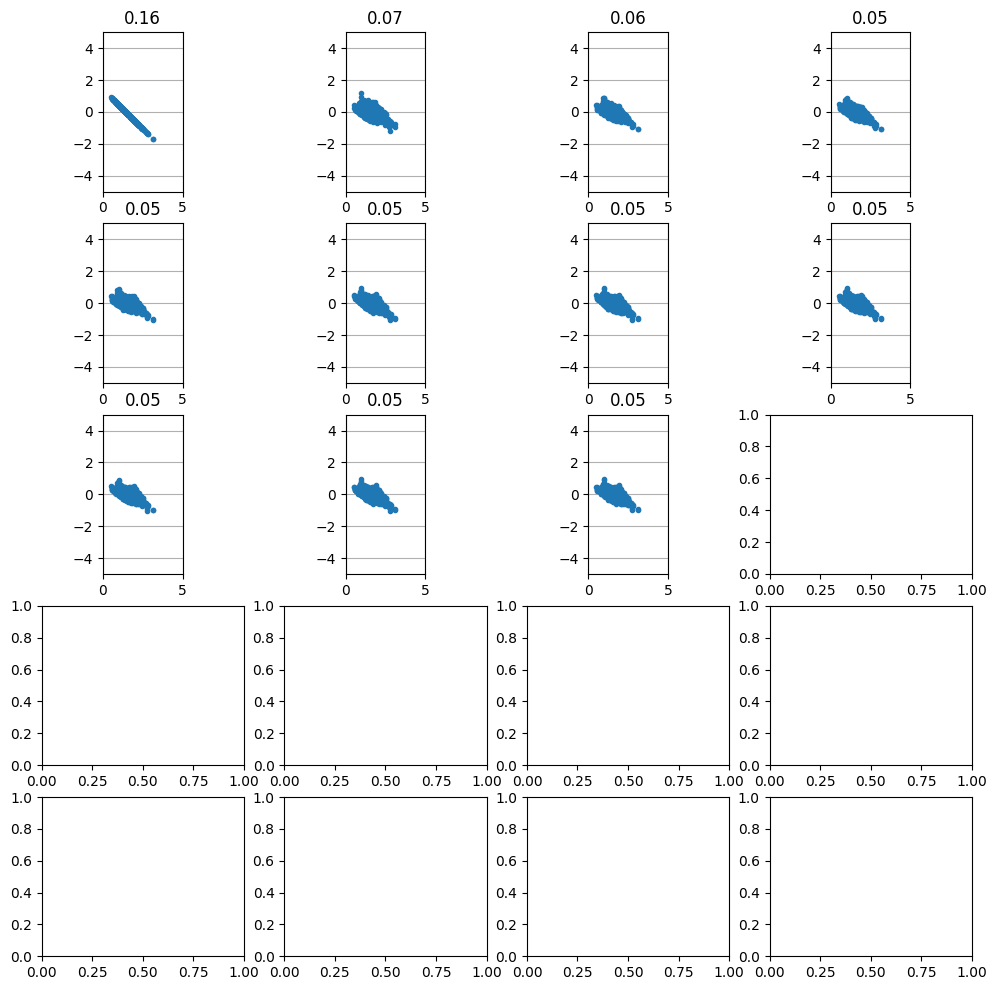

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))

it = np.linspace(0,19,20, dtype=int)  # Ensure indices are integers

# Iterate over the subplots and data
for ax, i in zip(axes.flatten(), it):  # Flatten axes for proper iteration
    ypredict_simpler = model.predict(X, index=i)  # Use integer index
    ax.plot(y,ypredict_simpler-y,'.')
    ax.grid(True)
    # ax.set_xlabel("Modeled LAI")
    # ax.set_ylabel("Measured LAI")
    # ax.plot( [0,5], [-5,5], linestyle='--', color='k' )

    ax.set_aspect('equal')
    ax.set_xlim(0, 5)
    ax.set_ylim(-5, 5)
    mse =np.power(ypredict_simpler - y, 2).mean()
    ax.set_title(round(mse,2))
    ax.grid(True)

# Adjust layout to prevent overlap
# plt.tight_layout()
plt.show()



# Other PySR Options

The full list of PySR parameters can be found here: https://ai.damtp.cam.ac.uk/pysr/api